In [4]:
# probably need a different python env for this, as tf and fmask may conflict
from fmask import fmask
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

In [5]:
modis_tower_path="/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/"
modis_win_path = "F:\\Bachelorarbeit\\sat-data\\modis\\MODIS_MOD09GA_GERITAFRA_31day_DEC2023\\"
modis_x_path = "/mnt/f/Bachelorarbeit/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/"
modis_path = modis_tower_path
day1 = "MOD09GA.A2023335.h18v04.061.2023340033530"

# Run Fmask on Two Prepared Files from One MODIS Product.
- MOD09GA.A2023335.h18v04.061.2023340033530_merged_2400_wgs84.tiff
- MOD09GA.A2023335.h18v04.061.2023340033530_upscaled_angles_2400_wgs84.tiff or
    - MOD09GA.A2023335.h18v04.061.2023340033530_solar_zenith_2400_wgs84.tiff
    
    ...
    - MOD09GA.A2023335.h18v04.061.2023340033530_sensor_azimuth_2400_wgs84.tiff

3.1 Input der Dateien und Bänder-Zuordnung in Fmask Config Objekte

In [6]:
# angles_config = fmask.config.AnglesFileInfo(modis_path+day1+"_solar_zenith_2400_wgs84.tiff", 0,
#                                             modis_path+day1+"_solar_azimuth_2400_wgs84.tiff", 0,
#                                             modis_path+day1+"_sensor_zenith_2400_wgs84.tiff", 0,
#                                             modis_path+day1+"_sensor_azimuth_2400_wgs84.tiff", 0)

In [10]:
class PreparedModisAnglesFileInfo(fmask.config.AnglesInfo):
    """
    self.modis_ga09_file = modis_ga09_file is the full filepath 
    self.solarZenithData = None : Translates to Solar Zenith angle
    self.solarAzimuthData = None
    self.viewZenithData = None : Translates to Sensor Zenith angle
    self.viewAzimuthData = None 
    """
    def __init__(self, modis_09ga_angle_file_path):
        self.modis_09ga_angle_file_path = modis_09ga_angle_file_path
        self.solarZenithData = None
        self.solarAzimuthData = None
        self.viewZenithData = None
        self.viewAzimuthData = None
        self.thermalInfo = None
        self.anglesInfo = None
        self.angleArray = []

    def getShape(self):
        self.readAngleFile()
        return self.angleArray.shape
    
    def readAngleFile(self):
        ds = gdal.Open(self.modis_09ga_angle_file_path)
        self.angleArray = ds.ReadAsArray()
        del ds

    def prepareForQuerying(self):
        """
        Called when fmask is about to query this object for angles.
        """
        self.readAngleFile()
        self.solarZenithData = self.angleArray[0]
        self.solarAzimuthData = self.angleArray[1]
        self.viewZenithData = self.angleArray[2]
        self.viewAzimuthData = self.angleArray[3]
    
    def releaseMemory(self):
        """
        Called when fmask has finished querying this object.
        """
        del self.solarZenithData
        del self.solarAzimuthData
        del self.viewZenithData
        del self.viewAzimuthData
        del self.angleArray
    
    def getSolarZenithAngle(self, indices):
        """
        Return the average solar zenith angle for the given indices
        """
        return np.deg2rad(self.solarZenithData[indices].mean())

    def getSolarAzimuthAngle(self, indices):
        """
        Return the average solar azimuth angle for the given indices
        """
        return np.deg2rad(self.solarAzimuthData[indices].mean())
    
    def getViewZenithAngle(self, indices):
        """
        Return the average view zenith angle for the given indices
        """
        return np.deg2rad(self.viewZenithData[indices].mean())

    def getViewAzimuthAngle(self, indices):
        """
        Return the average view azimuth angle for the given indices
        """
        return np.deg2rad(self.viewAzimuthData[indices].mean())

In [ ]:
# experiment params 
size = 2400
cloud_buffer_size=0
shadow_buffer_size=10

In [13]:
angles_config_2400 = PreparedModisAnglesFileInfo(modis_path+day1+f"_upscaled_angles_{size}_wgs84.tiff")


/home/mxh/anaconda3/envs/fmask/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [18]:
angles_config_2400.prepareForQuerying()
angles_config_2400.getSolarAzimuthAngle((2063, 2500))

119.25834778877254

In [21]:
fmask_config = fmask.config.FmaskConfig(fmask.config.FMASK_LANDSAT8)
fmask_file_config_2400 = fmask.config.FmaskFilenames(toaRefFile=f"{modis_tower_path+day1}_merged_{size}_wgs84.tiff", outputMask="merged_{size}_output_fmask.tiff")
fmask_file_config_2400_toa = fmask.config.FmaskFilenames(toaRefFile=f"{modis_tower_path+day1}_toa_{size}_wgs84.tiff", outputMask="toa_{size}_output_fmask.tiff")


fmask_config.setAnglesInfo(angles_config_2400)

fmask_config.setReflectiveBand(fmask.config.BAND_RED, 0)
fmask_config.setReflectiveBand(fmask.config.BAND_NIR, 1)
fmask_config.setReflectiveBand(fmask.config.BAND_BLUE, 2)
fmask_config.setReflectiveBand(fmask.config.BAND_GREEN, 3)
fmask_config.setReflectiveBand(fmask.config.BAND_CIRRUS, 4)
fmask_config.setReflectiveBand(fmask.config.BAND_SWIR1, 5)
fmask_config.setReflectiveBand(fmask.config.BAND_SWIR2, 6)

fmask_config.setVerbose(True)
fmask_config.setGdalDriverName("GTiff")
fmask_config.setCloudBufferSize(cloud_buffer_size)  # values from 0-5 seem to work well
fmask_config.setShadowBufferSize(shadow_buffer_size)


3.2 Run Fmask

In [22]:
# runtime > 397m
print("Angles (and thus sat-img) wgs84 Shape: ", angles_config_2400.getShape())
fmask.doFmask(fmask_file_config_2400, fmask_config)

Cloud layer, pass 1
Saturation mask not supplied - saturated areas may not be detected
  Twater= None Tlow= None Thigh= None NIR_17= 0.0 nonNullCount= 6036965
Cloud layer, pass 2
  landThreshold= 0.2
Cloud layer, pass 3
Potential shadows
Clumping clouds
Making 3d clouds
Making cloud shadow shapes
Matching shadows


In [ ]:
from matplotlib.colors import ListedColormap

fmask_color_mapping = {0:"black", 1:"yellow",2:"white", 3:"gray",4:"cyan", 5:"blue"}
cmap = ListedColormap([fmask_color_mapping[i] for i in range(6)])

fmask_pred = gdal.Open("merged_{size}_output_fmask.tiff").ReadAsArray()

plt.imshow(fmask_pred, vmin=0, vmax=5, cmap=cmap)
plt.colorbar(label="Fmask Code")
plt.title("Fmask cloud mask")
plt.show()

# Explore Fmask on MODIS

### Warp MODIS file to EPSG:4326 / WGS84

In [16]:
warp_options = gdal.WarpOptions(dstSRS="EPSG:4326")

warp = gdal.Warp(destNameOrDestDS=modis_tower_path+day1+"_wgs84.tmp.tif", srcDSOrSrcDSTab=modis_tower_path+day1+"_merged.tif", options=warp_options)
translate  = gdal.Translate(destName=modis_tower_path+day1+"_wgs84.tiff", srcDS=warp, format="GTiff", creationOptions=['TILED:YES'])
translate = None

In [4]:
#warp_options = gdal.WarpOptions(dstSRS="EPSG:9001")
warp_options = gdal.WarpOptions(dstSRS="EPSG:4326")

warp = gdal.Warp(destNameOrDestDS=modis_tower_path+day1+"_TOA_256_wgs84.tmp.tiff", srcDSOrSrcDSTab=modis_tower_path+day1+"_TOA_256.tiff", options=warp_options)
translate  = gdal.Translate(destName=modis_tower_path+day1+"_TOA_256_wgs84.tiff", srcDS=warp, format="GTiff", creationOptions=['TILED:YES'])
translate = None

/home/mxh/anaconda3/envs/fmask/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


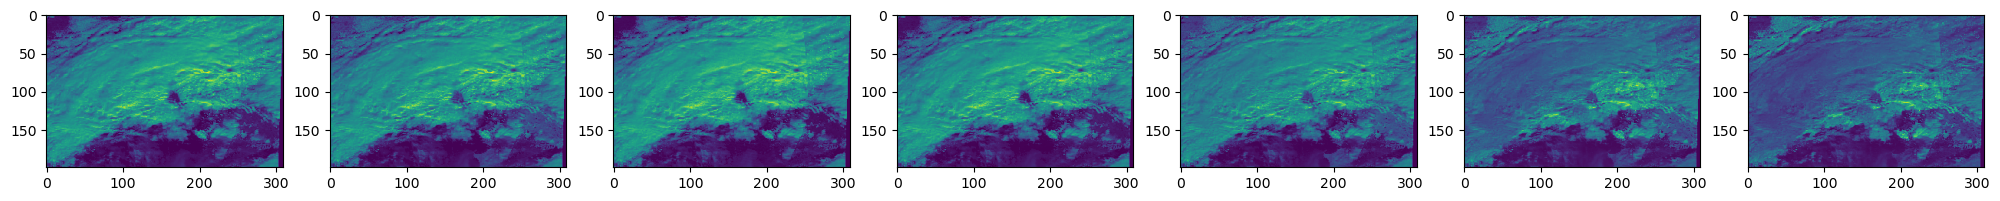

In [5]:
fmask_pred = gdal.Open(modis_tower_path+day1+"_TOA_256_wgs84.tiff").ReadAsArray()
fig, axes = plt.subplots(1,7, figsize=(25,25))

for i, ax in enumerate(axes.flat):
    ax.imshow(fmask_pred[i])

# reprojection seems to have changed image dimensions

In [8]:
class ModisAnglesFileInfo(fmask.config.AnglesInfo):
    """
    self.modis_ga09_file = modis_ga09_file is the full filepath 
    self.solarZenithData = None : Translates to Solar Zenith angle
    self.solarAzimuthData = None
    self.viewZenithData = None : Translates to Sensor Zenith angle
    self.viewAzimuthData = None 
    """
    def __init__(self, modis_ga09_file_path): #, SRS="EPSG:4326", warp=False):
        self.modis_ga09_file = modis_ga09_file_path
        self.solarZenithData = None
        self.solarAzimuthData = None
        self.viewZenithData = None
        self.viewAzimuthData = None
        self.thermalInfo = None
        self.anglesInfo = None

    @staticmethod
    def readSubsetData(subset_filename):
        ds = gdal.Open(subset_filename)
        data = ds.ReadAsArray()
        del ds
        return data

    # def warpModisAngle_s(self):
    #     # to SRS
    #     pass
    
    def readModisFile(self):
        ds = gdal.Open(self.modis_ga09_file)
        self.subsets = ds.GetSubDatasets()
        del ds

    def prepareForQuerying(self):
        """
        Called when fmask is about to query this object for angles.
        """
        self.readModisFile()
        self.solarZenithData = self.readSubsetData(self.subsets[5][0])
        self.solarAzimuthData = self.readSubsetData(self.subsets[6][0])
        self.viewZenithData = self.readSubsetData(self.subsets[2][0])
        self.viewAzimuthData = self.readSubsetData(self.subsets[3][0])
    
    def releaseMemory(self):
        """
        Called when fmask has finished querying this object.
        """
        del self.solarZenithData
        del self.solarAzimuthData
        del self.viewZenithData
        del self.viewAzimuthData
    
    def getSolarZenithAngle(self, indices):
        """
        Return the average solar zenith angle for the given indices
        """
        return np.deg2rad(self.solarZenithData[indices].mean())

    def getSolarAzimuthAngle(self, indices):
        """
        Return the average solar azimuth angle for the given indices
        """
        return np.deg2rad(self.solarAzimuthData[indices].mean())
    
    def getViewZenithAngle(self, indices):
        """
        Return the average view zenith angle for the given indices
        """
        return np.deg2rad(self.viewZenithData[indices].mean())

    def getViewAzimuthAngle(self, indices):
        """
        Return the average view azimuth angle for the given indices
        """
        return np.deg2rad(self.viewAzimuthData[indices].mean())

In [7]:
mod_ang_info_instance = ModisAnglesFileInfo("/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/MOD09GA.A2023335.h18v04.061.2023340033530.hdf")

In [1]:
mod_ang_info_instance.prepareForQuerying()
mod_ang_info_instance.solarZenithData.shape

NameError: name 'mod_ang_info_instance' is not defined

In [9]:
# constant solar Zenith angle implementation...
fmask_angles_config = ...#fmask.config.AnglesInfo(solarZenithFilename='HDF4_EOS:EOS_GRID:"/media/mxh/Volume/SAT-DATA/MODIS_MOD09GA_GERITAFRA_31day_DEC2023/MOD09GA.A2023335.h18v04.061.2023340033530.hdf":MODIS_Grid_1km_2D:SensorZenith_1',

In [19]:
hdf_fmask_file_config = fmask.config.FmaskFilenames(toaRefFile=f"{modis_tower_path+day1}_wgs84.tiff", outputMask="toa_output_fmask.tiff")
fmask_file_config = fmask.config.FmaskFilenames(toaRefFile=f"{modis_tower_path+day1}_TOA_256_wgs84.tiff", outputMask="toa_256_output_fmask.tiff")

fmask_config = fmask.config.FmaskConfig(fmask.config.FMASK_LANDSAT8)
fmask_config.setAnglesInfo(mod_ang_info_instance)

# fmask_config.setReflectiveBand(fmask.config.BAND_GREEN, 13)
# fmask_config.setReflectiveBand(fmask.config.BAND_BLUE, 12)
# fmask_config.setReflectiveBand(fmask.config.BAND_RED, 10)
# fmask_config.setReflectiveBand(fmask.config.BAND_NIR, 11)
# fmask_config.setReflectiveBand(fmask.config.BAND_CIRRUS, 14)
# fmask_config.setReflectiveBand(fmask.config.BAND_SWIR1, 15)
# fmask_config.setReflectiveBand(fmask.config.BAND_SWIR2, 16)


fmask_config.setReflectiveBand(fmask.config.BAND_RED, 0)
fmask_config.setReflectiveBand(fmask.config.BAND_NIR, 1)
fmask_config.setReflectiveBand(fmask.config.BAND_BLUE, 2)
fmask_config.setReflectiveBand(fmask.config.BAND_GREEN, 3)
fmask_config.setReflectiveBand(fmask.config.BAND_CIRRUS, 4)
fmask_config.setReflectiveBand(fmask.config.BAND_SWIR1, 5)
fmask_config.setReflectiveBand(fmask.config.BAND_SWIR2, 6)

fmask_config.setVerbose(True)
fmask_config.setGdalDriverName("GTiff")
fmask_config.setCloudBufferSize(0)  # values from 0-5 seem to work well
fmask_config.setShadowBufferSize(10)


In [20]:
res = fmask.doFmask(hdf_fmask_file_config, fmask_config)

Cloud layer, pass 1
Saturation mask not supplied - saturated areas may not be detected
  Twater= None Tlow= None Thigh= None NIR_17= 0.0 nonNullCount= 6036965
Cloud layer, pass 2
  landThreshold= 0.2
Cloud layer, pass 3
Potential shadows
Clumping clouds
Making 3d clouds
Making cloud shadow shapes


IndexError: index 1200 is out of bounds for axis 0 with size 1200

In [ ]:
# need to upscale solar/sensor zenith/azimuth data

# up/downscale with gdal!!!

In [42]:
fmask.OUTCODE_CLOUD

2

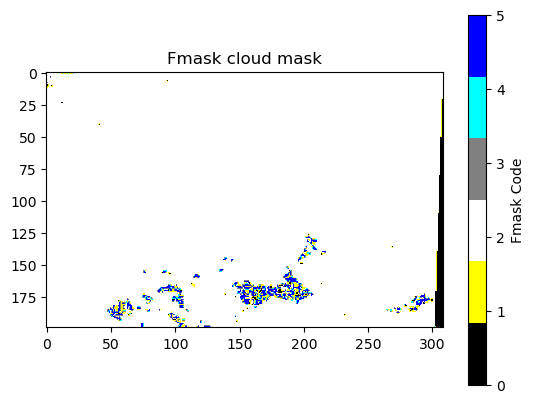

In [50]:
fmask_pred = gdal.Open("toa_256_output_fmask.tiff").ReadAsArray()
fmask_pred = gdal.Open("toa_output_fmask.tiff").ReadAsArray()
#fig, ax = plt.subplots(1,1, figsize=(25,25))

from matplotlib.colors import ListedColormap

fmask_color_mapping = {0:"black", 1:"yellow",2:"white", 3:"gray",4:"cyan", 5:"blue"}
cmap = ListedColormap([fmask_color_mapping[i] for i in range(6)])

plt.imshow(fmask_pred, vmin=0, vmax=5, cmap=cmap)
plt.colorbar(label="Fmask Code")
plt.title("Fmask cloud mask")
plt.show()

#### The values used in the final output raster
#: Output pixel value for null
OUTCODE_NULL = 0

#: Output pixel value for clear land
OUTCODE_CLEAR = 1

#: Output pixel value for cloud
OUTCODE_CLOUD = 2

#: Output pixel value for cloud shadow
OUTCODE_SHADOW = 3

#: Output pixel value for snow
OUTCODE_SNOW = 4

#: Output pixel value for water
OUTCODE_WATER = 5

In [51]:
fmask_pred

array([[1, 2, 2, ..., 2, 2, 4],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [1, 2, 2, ..., 0, 0, 0]], dtype=uint8)

### Now to run with higher prediction resolution: Patch and Stitch the image

In [ ]:

# predicted_mask, predicted_binary_mask = predict_img(model, params, img, n_bands, n_cls, params.num_gpus)



In [ ]:
def predict_image_modis(model, params, img, n_cls):
    